# QML for VBS - v2

## Imports

In [155]:
import time
t_start = time.time()

In [156]:
from qiskit import *
from qiskit import IBMQ, Aer

from qiskit.circuit import ParameterVector
from qiskit.visualization.bloch import Bloch
from qiskit.aqua.components.optimizers import SPSA
#from qiskit.algorithms.optimizers import SPSA
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import math
import pickle
import random 
from random import randrange
from sklearn.utils import shuffle

In [157]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

## Script parameters
* quantum_hw: set to '0' to use simulator or to '1' to use a real quantum computer;
* bknd: quantum computer used;
* Shots: number of attempts for each measuration to get a statistical result;
* max_circuits_supported: maximum number of circuits supported on Quantum Experience (use an number multiple of number_classes);
* layout: configuration of the qubits chosen from the quantum computer. It links each qubit of the algorithm to the corresponding qubits of the real hardware;
* number_training: number of events of each type used during the training phase;
* number_testing: number of events of each type used during the testing phase;
* SPSA_steps: number of steps for SPSA algorithm;
* number_var: total number of variables used to classify each event;
* number_classes: number of classes for which classification is performed;
* ii,jj,kk,ll,mm : numbers associated to the variables used for the classification of each event (their order is relevant);
* nn: index associated to the weights column;
* c_e_ii,c_e_jj,c_e_kk,c_e_ll,c_e_mm: crossentropy functions associated to the variables distributions;
* L1: Number of repetitions of the Mapping Circuit;
* L2: Number of repetitions of the Variational part of the Quantum Circuit;
* print_loss_func: 1-> prints the loss function evaluations, 0-> doesn't;
* plot_AUC_image: 1-> prints the AUC graph, 0-> doesn't;
* plot_data: 1-> prints the data images, 0-> doesn't;
* sound: 1-> acustic signal at the end of the execution, 0 -> no signal;
* save_results: 1 -> save result on an externjal file, 0 -> doesn't;


In [158]:
quantum_hw = 0
bknd = 'ibmq_manila'
Shots = 8192                        
max_circuits_supported = 7400        
layout = [0,1,2,3,4]

number_training = 100             
number_testing = 1000
SPSA_steps = 50          
number_var = 5                      
number_classes = 2                  
ratio = 1

ii = 35 
jj = 40
kk = 45
ll = 18
mm = 54
nn = 59 #weight_norm column index

c_e_ii = 8.703944283
c_e_jj = 8.312086411
c_e_kk = 8.270524837
c_e_ll = 8.157018642
c_e_mm = 7.354027826

ri=2
rj=2
rk=2
rl=0
rm=2

L1 = 1                 
L2 = 2                 


print_loss_func = 1     
plot_AUC_image = 1      
plot_data = 1 
sound = 0
save_results = 0

## Auxiliary functions

#### Definitions of useful functions
The following are useful to reshape the variables distributions before the mapping phase

In [159]:
def Cheb(x):
    return np.cos((x+1)*np.pi/2)

def InvCheb(x):
    return 2*np.arccos((x+1)/2)/np.pi-1

def Sqrt(x):
    x = np.clip(x,-1,1)
    return np.sqrt((x+1)/2)*2 -1

def InvSqrt(x):
    return ((x+1)**2 -1)/2

#### Labelling function
It labels the input events into the classes (implemented only for 2 classes)

In [160]:
def f_label(i):
    if i%2==0:
        result = [1,0]
    else:
        result = [0,1]
    return result

#### Normalization function (softmax function)

In [161]:
def softmax_function(x):
    F = [math.exp(x[0]),math.exp(x[1]),math.exp(x[2]),math.exp(x[3])]
    for i in range(0,2):
        F[i] = F[i]/sum([math.exp(x[0]),math.exp(x[1])])
    for i in range(2,4):
        F[i] = F[i]/sum([math.exp(x[2]),math.exp(x[3])])
    return F

#### Measuration  function
The following determines how measuration values obtained from the quantum circuit are treated in order to obtain a single result for each event

In [162]:
def f_measuration(count):
    Z_m = np.zeros(4)
    for i in range(0,2**(number_bits)):
        for k in range(0,4):
            if eig[i][1-k] == '0' and eig[i] in count:
                Z_m[k] += count[eig[i]]  

    Z_m = (2*np.array(Z_m)-Shots)/Shots
    y = softmax_function(Z_m)
    return y

#### Mapping function

In [163]:
def Phi_function(x,y,z,a,b):
    return [np.arcsin(y),np.arccos(y**2),np.arcsin(x),np.arccos(x**2),np.arcsin(z),np.arccos(z**2),np.arcsin(a),np.arccos(a**2),np.arcsin(b),np.arccos(b**2)] 
    #the length of the array has to be equal to the number of qubits

## Parameters introduction

In [164]:
def training_set(par,circuit,theta,Phi_f):
    #the following lines are destineted to the creation of the input for bind.parameters()
    pre_input = [[theta.params[k], par[k]] for k in range(0, number_parameters)]
    input_p2 = []
    for i in range(0,len(pre_input)):
        input_p2 = input_p2  + [pre_input[i][0]] + [pre_input[i][1]]
    the_input = [{Phi:Phi_f[i]} for i in range(0,len(X))]
    for i in range(0,len(X)):
        for j in range(0,len(pre_input)):
            the_input[i][pre_input[j][0]] = pre_input[j][1]

    #evaluation of the circuit with the parameters setted by the input, for all possible values in X
    Counts = []
    for j in range(0,N):
        circuits_dataset = [circuit.bind_parameters(the_input[i+j*max_circuits_supported]) for i in range(0,max_circuits_supported)]
        if quantum_hw == 1:
            provider = IBMQ.get_provider('ibm-q')
            qcomp = provider.get_backend(bknd)
        else:
            qcomp = Aer.get_backend('qasm_simulator')
        job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
        job_monitor(job)
        result = job.result()
        counts = result.get_counts()
        Counts = Counts + counts

    circuits_dataset = [circuit.bind_parameters(the_input[i+max_circuits_supported*N]) for i in range(0,remainder)]
    if quantum_hw == 1:
        provider = IBMQ.get_provider('ibm-q')
        qcomp = provider.get_backend(bknd)
    else:
        qcomp = Aer.get_backend('qasm_simulator')
    job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts()

    Counts = Counts + counts
    counts = Counts
    
#    ### Just to check that the circuits look right...
#    print(circuits_dataset[0].decompose())
    
    return counts

## Loading data for training
definition of functions to load data variable-per-variable properly deformed and rescaled in the interval [-1,1]

In [165]:
#calculate the number of events for each background in the sample considered
def number_of_events(X1):
    i=0
    top=0
    DY=0
    Wjets_HT=0
    VV=0
    VVV=0
    Vg=0
    VgS=0
    VBF_V=0
    Fake=0
    for i in range(len(X1)):
        if X1[i]=='top':
            top+=1
            continue
        if X1[i]=='DY':
            DY+=1
            continue
        if X1[i]=='Wjets_HT':
            Wjets_HT+=1
            continue
        if X1[i]=='VV':
            VV+=1
            continue
        if X1[i]=='VBF-V':
            VBF_V+=1
            continue
        if X1[i]=='VVV':
            VVV+=1
            continue
        if X1[i]=='Vg':
            Vg+=1
            continue
        if X1[i]=='VgS':
            VgS+=1
            continue
        if X1[i]=='Fake':
            Fake+=1
            continue
    return top, DY, Wjets_HT,VV,VBF_V,VVV,Vg,VgS,Fake

def load_training(aa):
    X1 = np.array(data1[Ind[aa]])
    X2 = np.array(data2[Ind[aa]])

    X = []
    num_events=number_training//9
    for i in range(0,number_training):
        X.append(X1[i])
        if i < num_events:
            X.append(X2[i])
        if num_events <= i < 2*num_events:
            X.append(X2[top+i-num_events])
        if 2*num_events <= i < 3*num_events:
            X.append(X2[top+DY+i-2*num_events])
        if 3*num_events<= i < 4*num_events:
            X.append(X2[top+DY+Wjets_HT+i-3*num_events])
        if 4*num_events<= i <5*num_events:
            X.append(X2[top+DY+Wjets_HT+VV+i-4*num_events])
        if 5*num_events<= i <6*num_events:
            X.append(X2[top+DY+Wjets_HT+VV+VBF_V+i-5*num_events])
        if 6*num_events<= i <7*num_events:
            X.append(X2[top+DY+Wjets_HT+VV+VBF_V+VVV+i-6*num_events])
        if 7*num_events<= i <8*num_events:
            X.append(X2[top+DY+Wjets_HT+VV+VBF_V+VVV+Vg+i-7*num_events])
        if 8*num_events<= i <9*num_events:
            X.append(X2[top+DY+Wjets_HT+VV+VBF_V+VVV+Vg+VgS+i-8*num_events])
        if 9*num_events<= i:
            X.append(X2[top+DY+i-8*num_events])
    return X

def load_testing(aa):
    X1 = np.array(data1[Ind[aa]])
    X2 = np.array(data2[Ind[aa]])
    
    X = []
    for i in range(number_training,number_training + number_testing):
        X.append(X1[i])
        X.append(X2[i])
    return X

def rescaling(X,reshape):
    Xmax = max(X)
    Xmin = min(X)

    #X are normalizated over [-1,1]
    if Xmax-Xmin != 0:
        X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
    X = np.array(X) -1
    if reshape==0:
        X = Cheb(X)
    if reshape==1:
        X = InvCheb(X)
    if reshape==2:
        X = Sqrt(X)
    if reshape==3:
        X = InvSqrt(X)
    X = np.clip(X,-1,1)
    
    X1 = []
    X2 = []
    for i in range(0,len(X)):
        if i % 2 == 0:
            X1.append(X[i])
        else:
            X2.append(X[i])
    return X,X1,X2

top = 24619 DY = 61371 Wjets_HT = 257503 VV = 70934 VBF-V = 743 VVV = 653 Vg = 215 VgS = 212 Fake = 13184
top = 11 DY = 11 Wjets_HT = 12 VV = 11 VBF-V = 11 VVV = 11 Vg = 11 VgS = 11 Fake = 11


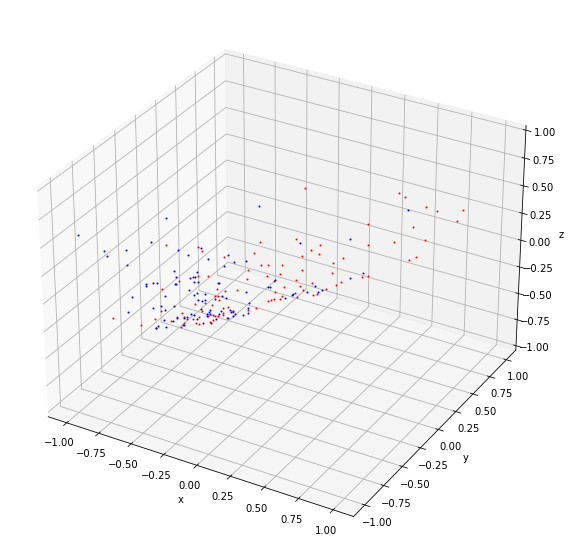

In [166]:
#DATA CAPTURE
#Here data are normalized in [-1,1] and, eventually, "stretched" or "squized" by using the functions just defined.
#Odd and even elements of the following vectors will appartain to different classes (by choice)

data1 = pickle.load(open("signal_balanced.pkl","rb"))
data2 = pickle.load(open("background_balanced.pkl","rb")) 
Ind = data1.columns

#total number of events of each background
S=np.array(data2[Ind[57]])
top, DY, Wjets_HT,VV,VBF_V,VVV,Vg,VgS,Fake=number_of_events(S)
print('top =',top,'DY =', DY,'Wjets_HT =', Wjets_HT,'VV =', VV,'VBF-V =',VBF_V,'VVV =',VVV,'Vg =', Vg,'VgS =',VgS,'Fake =', Fake)
#print(len(S), top+DY+Wjets_HT+VV+VBF_V+VVV+Vg+VgS+Fake)

X=load_training(ii)
Y=load_training(jj)
Z=load_training(kk)
A=load_training(ll)
B=load_training(mm)
X,X1,X2=rescaling(X,ri)
Y,Y1,Y2=rescaling(Y,rj)
Z,Z1,Z2=rescaling(Z,rk)
A,A1,A2=rescaling(A,rl)
B,B1,B2=rescaling(B,rm)
W=load_training(nn)

#balancing signal and background weights
W1 = []
W2 = []
sum1=0
sum2=0
for i in range(0,len(X)):
        if i % 2 == 0:
            W1.append(W[i])
            sum1 += W[i]
        else:
            W2.append(W[i])
            sum2 += W[i]

balance=sum2/sum1
W2=W2/balance

#sum2=0
#for i in range(0,len(W2)):
#        sum2 += W2[i]
#print(sum1,sum2)

#number of events of each background for the training
S=load_training(57)
top, DY, Wjets_HT,VV,VBF_V,VVV,Vg,VgS,Fake=number_of_events(S)
print('top =',top,'DY =', DY,'Wjets_HT =', Wjets_HT,'VV =', VV,'VBF-V =',VBF_V,'VVV =',VVV,'Vg =', Vg,'VgS =',VgS,'Fake =', Fake)

############################################################

#TRAINING SET VISUALIZATION
if plot_data == 1:
    %matplotlib inline
    fig5 = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 1)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 1)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z') 

## Preparing for the training
division of the initial vector in smaller vectors in order to fit "max_circuits_supported"

In [167]:
#this part of the program is needed in the case where there exists a maximal number of trainable circuits per-time
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

training set mapping function

In [168]:
number_qubits = 1 #for EACH variable
number_bits = number_classes*2

#evaluation of phi
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i],A[i],B[i])[j]

training set mapping function

In [169]:
#defining the label function for the trainingset, remember that odd and even events correspond to different classes

f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

#### Build the variational circuit

In [170]:
number_parameters = 4*number_qubits*number_var

Phi = ParameterVector('Φ', 2*number_var) #int(number_qubits*(number_qubits+1)/2)
theta = ParameterVector('θ',number_parameters)

## Circuit construction

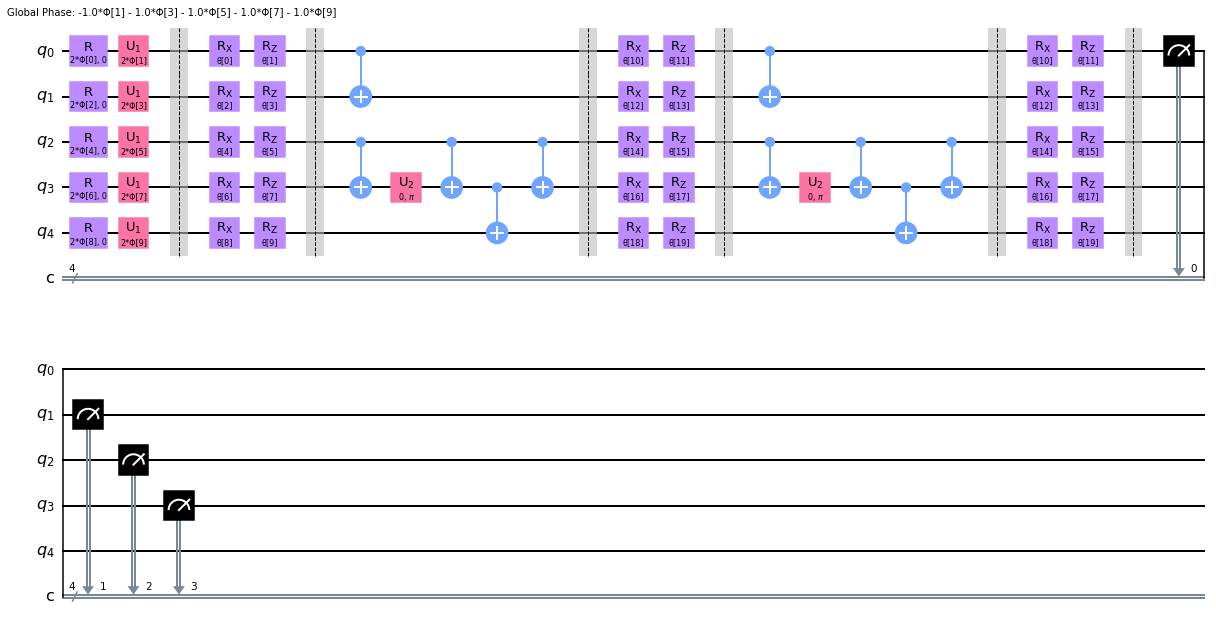

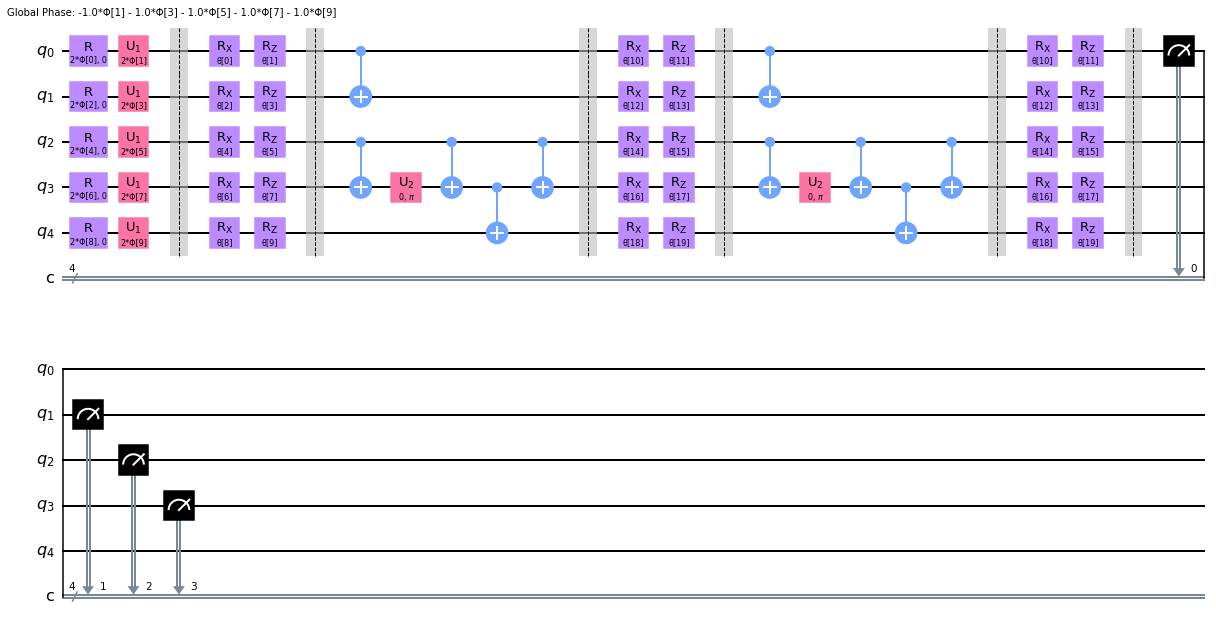

In [171]:
circuit = QuantumCircuit(number_var*number_qubits, number_bits)

for i in range(0,L1):

    for j in range(0,number_var):
        for k in range(0,number_qubits):
            circuit.rx(2*Phi[j*2],j+(number_var)*k)  
            circuit.rz(2*Phi[j*2+1],j+(number_var)*k) 
circuit.barrier()

#rotations
s = 0
for i in range(0,number_qubits*number_var):
    variational_circuit = QuantumCircuit(1)
    variational_circuit.rx(theta[s],0)
    s += 1
    variational_circuit.rz(theta[s],0)
    s += 1
    var_inst = variational_circuit.to_instruction()

    circuit.append(var_inst,[i])
circuit.barrier()
S = s

for k in range(0,L2):    
    #entanglement  

    circuit.cx(0,1)
    circuit.cx(2,3)
    circuit.h(3)
    circuit.cx(2,3)
    circuit.cx(3,4)
    circuit.cx(2,3)

    
    circuit.barrier()
    
    #rotations
    s = S
    for i in range(0,number_qubits*number_var):
        variational_circuit = QuantumCircuit(1)
        variational_circuit.rx(theta[s],0)
        s += 1
        variational_circuit.rz(theta[s],0)
        s += 1
        var_inst = variational_circuit.to_instruction()

        circuit.append(var_inst,[i])
    circuit.barrier()

    
# circuit.measure(range(0,2),range(0,2))
circuit.measure(range(0,4),range(0,4))

%matplotlib inline 
circuit.decompose().draw('mpl')

## Cost function production and plot
The cost function is chosen to be the kullback-Leibler divergence

<IPython.core.display.Javascript object>


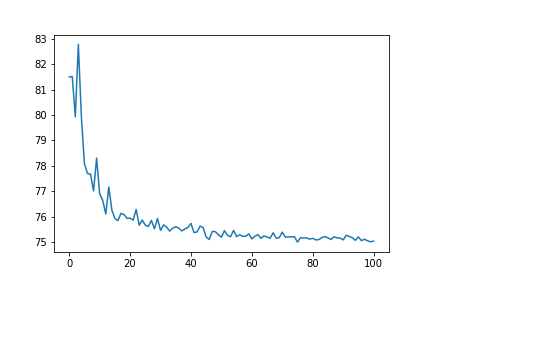

In [172]:
%matplotlib notebook

X_plot = []
Y_plot = []

fig = plt.figure()
ax = fig.add_subplot()
plt.ion()

fig.show()
fig.canvas.draw()
iter_count = 0

def plot_cost_fun(y):
    global iter_count
    global X_plot
    global Y_plot
    X_plot.append(iter_count)
    Y_plot.append(y)
    ax.clear()
    ax.plot(X_plot,Y_plot)
    fig.canvas.draw()
    iter_count += 1   

def cost_function(par,*args): #par will contain the parameters at each step of the optimization

    circuit = args[0]
    theta = args[1]
    Phi_f = args[2]
    W = args[3]
    
    counts = training_set(par,circuit,theta,Phi_f)

    L = 0
    print("\n current value of parameters: " , par )
      
    #estimated label 
    for i in range(0,len(X)):
        for k in range(0,2):
            yi = f_measuration(counts[i])
            Yi = ((c_e_ii+c_e_jj)*yi[k] + (c_e_kk+c_e_ll)*yi[2+k])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)  
            L += (-f_l[i][k]*math.log(Yi))*(((i+1)%2)*ratio + i%2)*W[i]
            
    if print_loss_func == 1:
        plot_cost_fun(L)
    
    print("current value for loss function: " , L , "\n\n" )
    return L

## Training

In [173]:
factor = 100

#creation of the eigenstates list, i.e: ['000', '001',... ]
eig = []
for i in range(0,2**(number_bits)):
    eig.append('')

for j in range(0,number_bits):
    for i in range(0,2**j): 
        for k in range(0,(2**(number_bits-j))):            
            if (k % 2) == 0:
                eig[i+k*2**j] = '0' + eig[i+k*2**j] 
            else:
                eig[i+k*2**j] = '1' + eig[i+k*2**j]  

In [174]:
#initial values for parameters are chosen randomly
theta_0 = []

for i in range(0, number_parameters):
    theta_0.append(random.uniform(0, 2*np.pi))
theta_0 = np.array(theta_0)

#In the following c0 is the firt step "a", c1 is the initial "c", c2 is the "alpha" parameter, c3 the "gamma" parameter
#and finally c4 another parameter to control "a" (as like as "alpha" does)
t = time.time()

Optimizer = SPSA(maxiter = 1e3, save_steps = 1, last_avg = 1, c0 = 10/(number_training), c1 = 0.3, c2 = 1, c3 = 0.7, c4 = 0, 
                 skip_calibration = False)

# cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
#     Optimizer._optimization(cost_function,theta_0, SPSA_steps, save_steps = 1, last_avg = 3))

fw = Optimizer.wrap_function(cost_function,(circuit,theta,Phi_f,W))

cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
    Optimizer._optimization(fw,theta_0, SPSA_steps, save_steps = 1, last_avg = 3) )

print(cost_final,theta_best)

elapsed = time.time() - t
print(elapsed)

Job Status: job has successfully run

 current value of parameters:  [ 1.65685041  4.97913386  0.77295146  5.23748043  1.90642202  1.56940164
 -0.01039288  4.74406781  5.8162106   3.66874056  1.98092531  4.61458505
  4.41582149  4.67276973  2.99726133  3.23888652  2.33819787  3.98928789
  4.61063517  0.04558055]
current value for loss function:  81.492815626882 


Job Status: job has successfully run

 current value of parameters:  [2.25685041 5.57913386 1.37295146 5.83748043 2.50642202 2.16940164
 0.58960712 5.34406781 6.4162106  3.06874056 2.58092531 5.21458505
 5.01582149 5.27276973 2.39726133 2.63888652 2.93819787 4.58928789
 5.21063517 0.64558055]
current value for loss function:  81.50995199329867 


Job Status: job has successfully run

 current value of parameters:  [1.76932269 5.09160614 1.25476706 5.34995271 2.01889429 2.05121724
 0.47142272 4.85654008 6.2980262  3.18692496 2.09339758 5.09640065
 4.89763709 5.15458533 2.88478905 3.12641424 2.82001347 4.4711035
 4.72310745 0.5

current value for loss function:  75.66980604019788 


Job Status: job has successfully run

 current value of parameters:  [1.38727158 5.1312158  1.26435979 4.93469321 1.90900089 2.09456215
 0.63754898 5.18099817 6.57593346 2.76680644 2.36865329 5.45829412
 5.58482975 5.89346821 3.19915397 3.7552934  3.4954569  4.28114462
 4.12008786 1.00885288]
current value for loss function:  75.87589462305712 


Job Status: job has successfully run

 current value of parameters:  [1.2876414  5.23084597 1.16472962 5.03432338 1.80937071 1.99493197
 0.5379188  5.28062835 6.67556364 2.86643662 2.46828346 5.35866395
 5.48519957 5.79383803 3.29878415 3.85492358 3.59508708 4.18151444
 4.02045768 0.90922271]
current value for loss function:  75.67003691899806 


Job Status: job has successfully run

 current value of parameters:  [1.27426572 5.24422166 1.15135393 5.04769907 1.79599503 1.98155629
 0.61913669 5.19941046 6.68893932 2.87981231 2.38706558 5.34528826
 5.56641746 5.87505592 3.21756626 3.86829926

Job Status: job has successfully run

 current value of parameters:  [1.39589569 5.21190327 1.09697654 5.02861085 1.92766499 2.09033726
 0.59701869 5.27380821 6.75603799 2.91951407 2.44802428 5.39605971
 5.59358616 5.92355154 3.15646296 3.76768052 3.51373461 4.27080567
 4.05969876 0.88570484]
current value for loss function:  75.41743074009224 


Job Status: job has successfully run

 current value of parameters:  [1.33285903 5.1488666  1.16001321 5.09164752 1.86462833 2.02730059
 0.53398202 5.33684488 6.69300132 2.98255073 2.38498761 5.45909638
 5.65662283 5.9865882  3.21949963 3.83071719 3.45069795 4.207769
 4.12273543 0.94874151]
current value for loss function:  75.29882817580521 


Job Status: job has successfully run

 current value of parameters:  [1.3875162  5.14219421 1.10535603 5.03699034 1.9192855  2.08195777
 0.5886392  5.34351727 6.68632893 2.98922313 2.37831522 5.46576877
 5.60196565 5.93193103 3.22617202 3.83738958 3.44402556 4.20109661
 4.12940782 0.89408433]
current va

Job Status: job has successfully run

 current value of parameters:  [1.39420773 5.14670325 1.11749505 5.02442819 1.91084271 2.12561291
 0.56415729 5.38927007 6.72278707 2.9480537  2.35468518 5.40707079
 5.6247494  5.97285744 3.14948788 3.80946075 3.45123303 4.17857497
 4.12345657 0.8647193 ]
current value for loss function:  75.21255151548019 


Job Status: job has successfully run

 current value of parameters:  [1.34629951 5.09879503 1.06958683 4.97651997 1.95875093 2.07770468
 0.51624907 5.34136185 6.67487885 2.99596192 2.4025934  5.45497901
 5.67265762 5.92494922 3.1973961  3.85736898 3.40332481 4.22648319
 4.17136479 0.91262752]
current value for loss function:  75.21140962427326 


Job Status: job has successfully run

 current value of parameters:  [1.39370029 5.09917363 1.11698761 5.02392075 1.91135015 2.07808329
 0.51662767 5.34174045 6.67525745 2.94856114 2.4022148  5.40757823
 5.62525684 5.97235    3.14999532 3.85699037 3.40370342 4.17908241
 4.17098619 0.86522674]
current 

Job Status: job has successfully run

 current value of parameters:  [1.36338894 5.12619712 1.06069806 4.95505016 1.93453055 2.12237382
 0.59122309 5.3954404  6.66995542 2.96142341 2.39890446 5.40674679
 5.62071539 5.97202555 3.20964413 3.81088592 3.4194278  4.2161244
 4.12579841 0.91653129]
current value for loss function:  75.06565966328391 


Job Status: job has successfully run

 current value of parameters:  [1.32403266 5.08684084 1.10005434 4.99440644 1.97388682 2.08301755
 0.55186681 5.35608413 6.7093117  3.00077968 2.35954818 5.44610307
 5.66007166 5.93266928 3.17028785 3.8502422  3.45878408 4.17676812
 4.16515469 0.87717501]
current value for loss function:  75.12138650297017 


Job Status: job has successfully run

 current value of parameters:  [1.36600232 5.1288105  1.05808468 4.9912404  1.93191716 2.12498721
 0.59383647 5.35925017 6.66734204 2.95881003 2.36271422 5.40413341
 5.65690563 5.97463893 3.21225751 3.80827254 3.41681442 4.17993416
 4.16198865 0.91914467]
current v

## Load data for testing
data loading variable-per-variable

top = 55 DY = 160 Wjets_HT = 614 VV = 142 VBF-V = 2 VVV = 4 Vg = 0 VgS = 0 Fake = 23


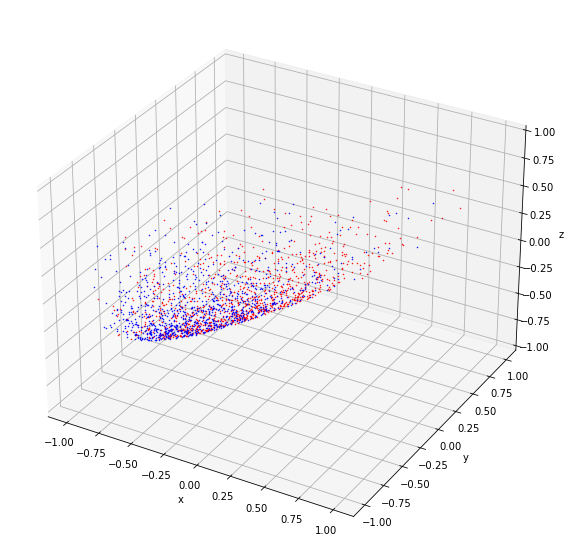

In [175]:
#data shuffling
data1 = shuffle(data1, random_state=1)
data2 = shuffle(data2, random_state=1)

#number of events of each background for the test
S=load_testing(57)
top, DY, Wjets_HT,VV,VBF_V,VVV,Vg,VgS,Fake=number_of_events(S)
print('top =',top,'DY =', DY,'Wjets_HT =', Wjets_HT,'VV =', VV,'VBF-V =',VBF_V,'VVV =',VVV,'Vg =', Vg,'VgS =',VgS,'Fake =', Fake)

#load, normalize and rescale variables
X=load_testing(ii)
Y=load_testing(jj)
Z=load_testing(kk)
A=load_testing(ll)
B=load_testing(mm)

X,X1,X2=rescaling(X,ri)
Y,Y1,Y2=rescaling(Y,rj)
Z,Z1,Z2=rescaling(Z,rk)
A,A1,A2=rescaling(A,rl)
B,B1,B2=rescaling(B,rm)


#TESTING SET VISUALIZATION
if plot_data == 1:
    %matplotlib inline
    fig4 = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 0.5)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 0.5)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z')  

## Preparing for testing
division of the initial vector in smaller vectors in order to fit "max_circuits_supported"

In [176]:
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

testing set mapping function

In [177]:
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i],A[i],B[i])[j]

traing set labels

In [178]:
f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

## Testing & AUC

#### ROC production

Job Status: job has successfully run


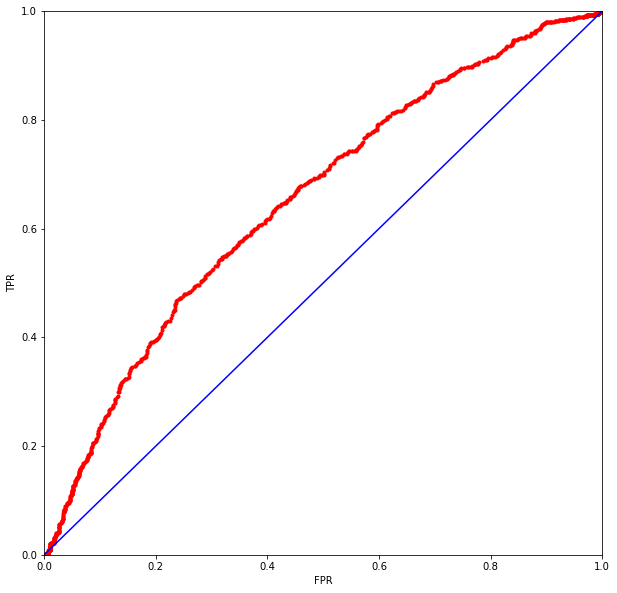

In [179]:
%matplotlib inline  
if plot_AUC_image == 1:
    fig2 = plt.figure(figsize = (10,10)) 
    plt.ylim((0,1))
    plt.xlim((0,1))

counts = training_set(theta_best,circuit,theta,Phi_f)

index_sorted = []
classification = []
for i in range(0,len(X)):
    classification.append(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[i])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)) 

sort_index = np.argsort(classification)

Classification = []
Labelling = []
for i in range(0,len(X)):
    Classification.append(((c_e_ii+c_e_jj)*f_measuration(counts[sort_index[i]])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll))  
    Labelling.append((sort_index[i]+1)%2)

treshold = np.linspace(0,1,2000)
False_positive_rate = []
True_positive_rate = []

for k in range(0,len(treshold)):
    C = Classification > treshold[k]
    false_negatives = sum((Labelling - C) == np.int_(np.ones(len(X))))
    false_positives = sum(np.array(Labelling - C) ==np.int_(-np.ones(len(X)))) 
    true_positives = sum(Labelling) - false_negatives 
    true_negatives = sum((Labelling) == np.int_(np.zeros(len(X)))) - false_positives

    False_positive_rate.append(false_positives/(false_positives+true_negatives+0.000001))
    True_positive_rate.append(true_positives/(true_positives+false_negatives+0.000001))
    if plot_AUC_image == 1:
        plt.plot(False_positive_rate[k],True_positive_rate[k],'ro',label = "ROC", markersize=3)
        
if plot_AUC_image == 1:    
    plt.plot(treshold,treshold,'b', markersize=3)    
    plt.xlabel('FPR')
    plt.ylabel('TPR')

#### AUC evaluation
(should be improved with Simpson rule)

In [180]:
def sorter(x,y):
    index = np.zeros(len(x))
    for k in range(0,len(x)):
        min = x[k]
        index[k] = k
        for i in range(k,len(x)):
            if x[i] < min:
                index[k] = i
        buffer = x[k] 
        x[k] = x[int(index[k])]
        x[int(index[k])] = buffer
        buffer = y[k] 
        y[k] = y[int(index[k])]
        y[int(index[k])] = buffer
    return x,y
    
False_positive_rate, True_positive_rate = sorter(False_positive_rate, True_positive_rate)

AUC = 0
for k in range(0,len(False_positive_rate)-1):
    AUC += (True_positive_rate[k]+True_positive_rate[k+1])*(False_positive_rate[k+1]-False_positive_rate[k])/2

print(AUC)

0.6538054986923891


#### Simpson rule

In [181]:
AUC2 = 0
for k in range(0,len(True_positive_rate)-2,2):
    AUC2+=0.5*(False_positive_rate[k+2]-False_positive_rate[k])/3*(True_positive_rate[k]+4*True_positive_rate[k+1]+True_positive_rate[k+2])
print(AUC2)

0.6537763320257811


#### Resulting visualzation

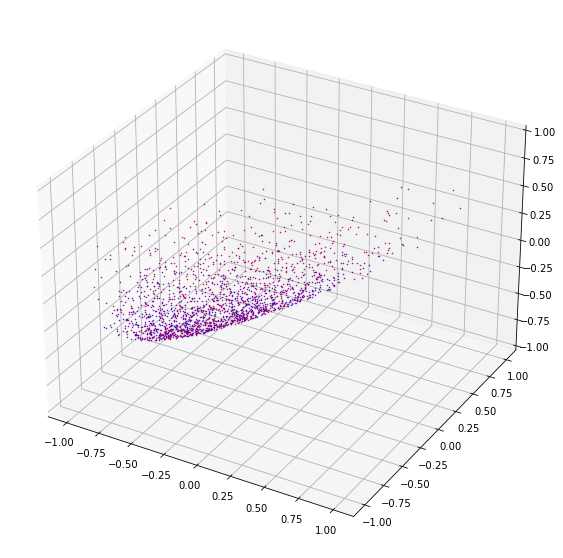

In [182]:
import matplotlib.pyplot as plt
%matplotlib inline  
fig3 = plt.figure(figsize = (10,10)) 
ax = plt.axes(projection='3d')

classificator = []
f_m = []
for i in range(0,len(X)):
    f_m.append(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[i])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll))

Min = min(f_m)
Max = max(f_m)
delta = Max - Min
    
for i in range(0,len(X)):
    x = [X[i]]
    y = [Y[i]]
    z = [Z[i]]
    ax.plot3D(x,y,z,'o',color = [np.clip((((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)-Min)/delta,0,1), 0, np.clip(1-(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)-Min)/delta,0,1)] ,markersize = 0.5)

if sound == 1:
    import winsound
    frequency = 1000  # Set Frequency To 2500 Hertz
    duration = 1000 # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)

## Saving results on file

In [183]:
tot_time = time.time() - t_start

def sec_to_hour(seconds: float):
    hour = seconds/3600
    min = (hour - int(hour))*60
    sec = (min -int(min))*60
    hour = int(hour)
    min = int(min)
    time = ("{} h, {} min and {:.0f} sec".format(hour,min,sec))
    return time

if save_results == 1:  
    ora=time.localtime()
    ora=str(ora.tm_year)+'_'+str(ora.tm_mon)+'_'+str(ora.tm_mday)+'_'+str(ora.tm_hour)+'_'+str(ora.tm_min)+'_'+str(ora.tm_sec)
    if quantum_hw==0:
        nome_file='simulator_record_'+ora+'.txt'
    else:
        nome_file='real_device_'+bknd+'_record_'+ora+'.txt'
    file1 = open(nome_file,"a")
    FP = str(False_positive_rate).strip('[]')
    TP = str(True_positive_rate).strip('[]')
    FM = str(f_m).strip('[]')
    TB = str(theta_best).strip('[]')

    file1.write("BEGIN ATTEMPT \n\n")
    file1.write("number_training = %d \n" %number_training)
    file1.write("number_testing  = %d \n" %number_testing)
    file1.write("SPSA_steps      = %d \n" %SPSA_steps)
    file1.write("number_var      = %d \n" %number_var)
    file1.write("variables       = %d, %d, %d, %d, %d\n" % (ii, jj, kk, ll, mm))
    file1.write("AUC             = %f \n" %AUC)
    file1.write("Training time(s)= %d \n" %elapsed) 
    file1.write("Total time (s)  = %d " %tot_time + "(" + sec_to_hour(tot_time) + ")\n")
    file1.write("Loss value      = %f \n" %cost_final)
    file1.write("\nParameters: \n"+TB+"\n")
    file1.write("\nFalse Positives: \n\n"+FP+ "\n\n"+"True Positives: \n\n"+TP+ "\n\n"+"f_measuration: \n\n"+FM + "\n\n\n\n\n")
    file1.close() 
    
    fig2.savefig('AUC_'+ora+'.png')
    fig.savefig('Loss_'+ora+'.png')